=== Timing Error Detector Analysis ===
Calculating kd values for loop filter design...

Gardner TED (β = 0.5): kd = -0.202344
MG TED (β = 0.1): kd = -0.247109

ANALOG PI LOOP FILTER DESIGN
Design Specifications:
- Damping ratio (ζ): 0.707
- Symbol period (T): 1.0
- Noise bandwidth values (BL): [0.0005, 0.005]


Gardner (β=0.5) (kd = -0.202344):
--------------------------------------------------

Noise Bandwidth BL = 5.0e-04:
  Filter Gains:
    kp (proportional): -0.013178
    ki (integral):     -0.000018
  Loop Parameters:
    Natural frequency (wn):     0.001886 rad/s
    Actual bandwidth (BL):      0.000500 Hz
  Performance:
    Actual damping ratio:       0.707000
    Settling time:              3000.302091 s
    Settling time (symbols):    3000.302091
    Peak overshoot:             4.33%

Noise Bandwidth BL = 5.0e-03:
  Filter Gains:
    kp (proportional): -0.131775
    ki (integral):     -0.001757
  Loop Parameters:
    Natural frequency (wn):     0.018857 rad/s
    Actual bandw

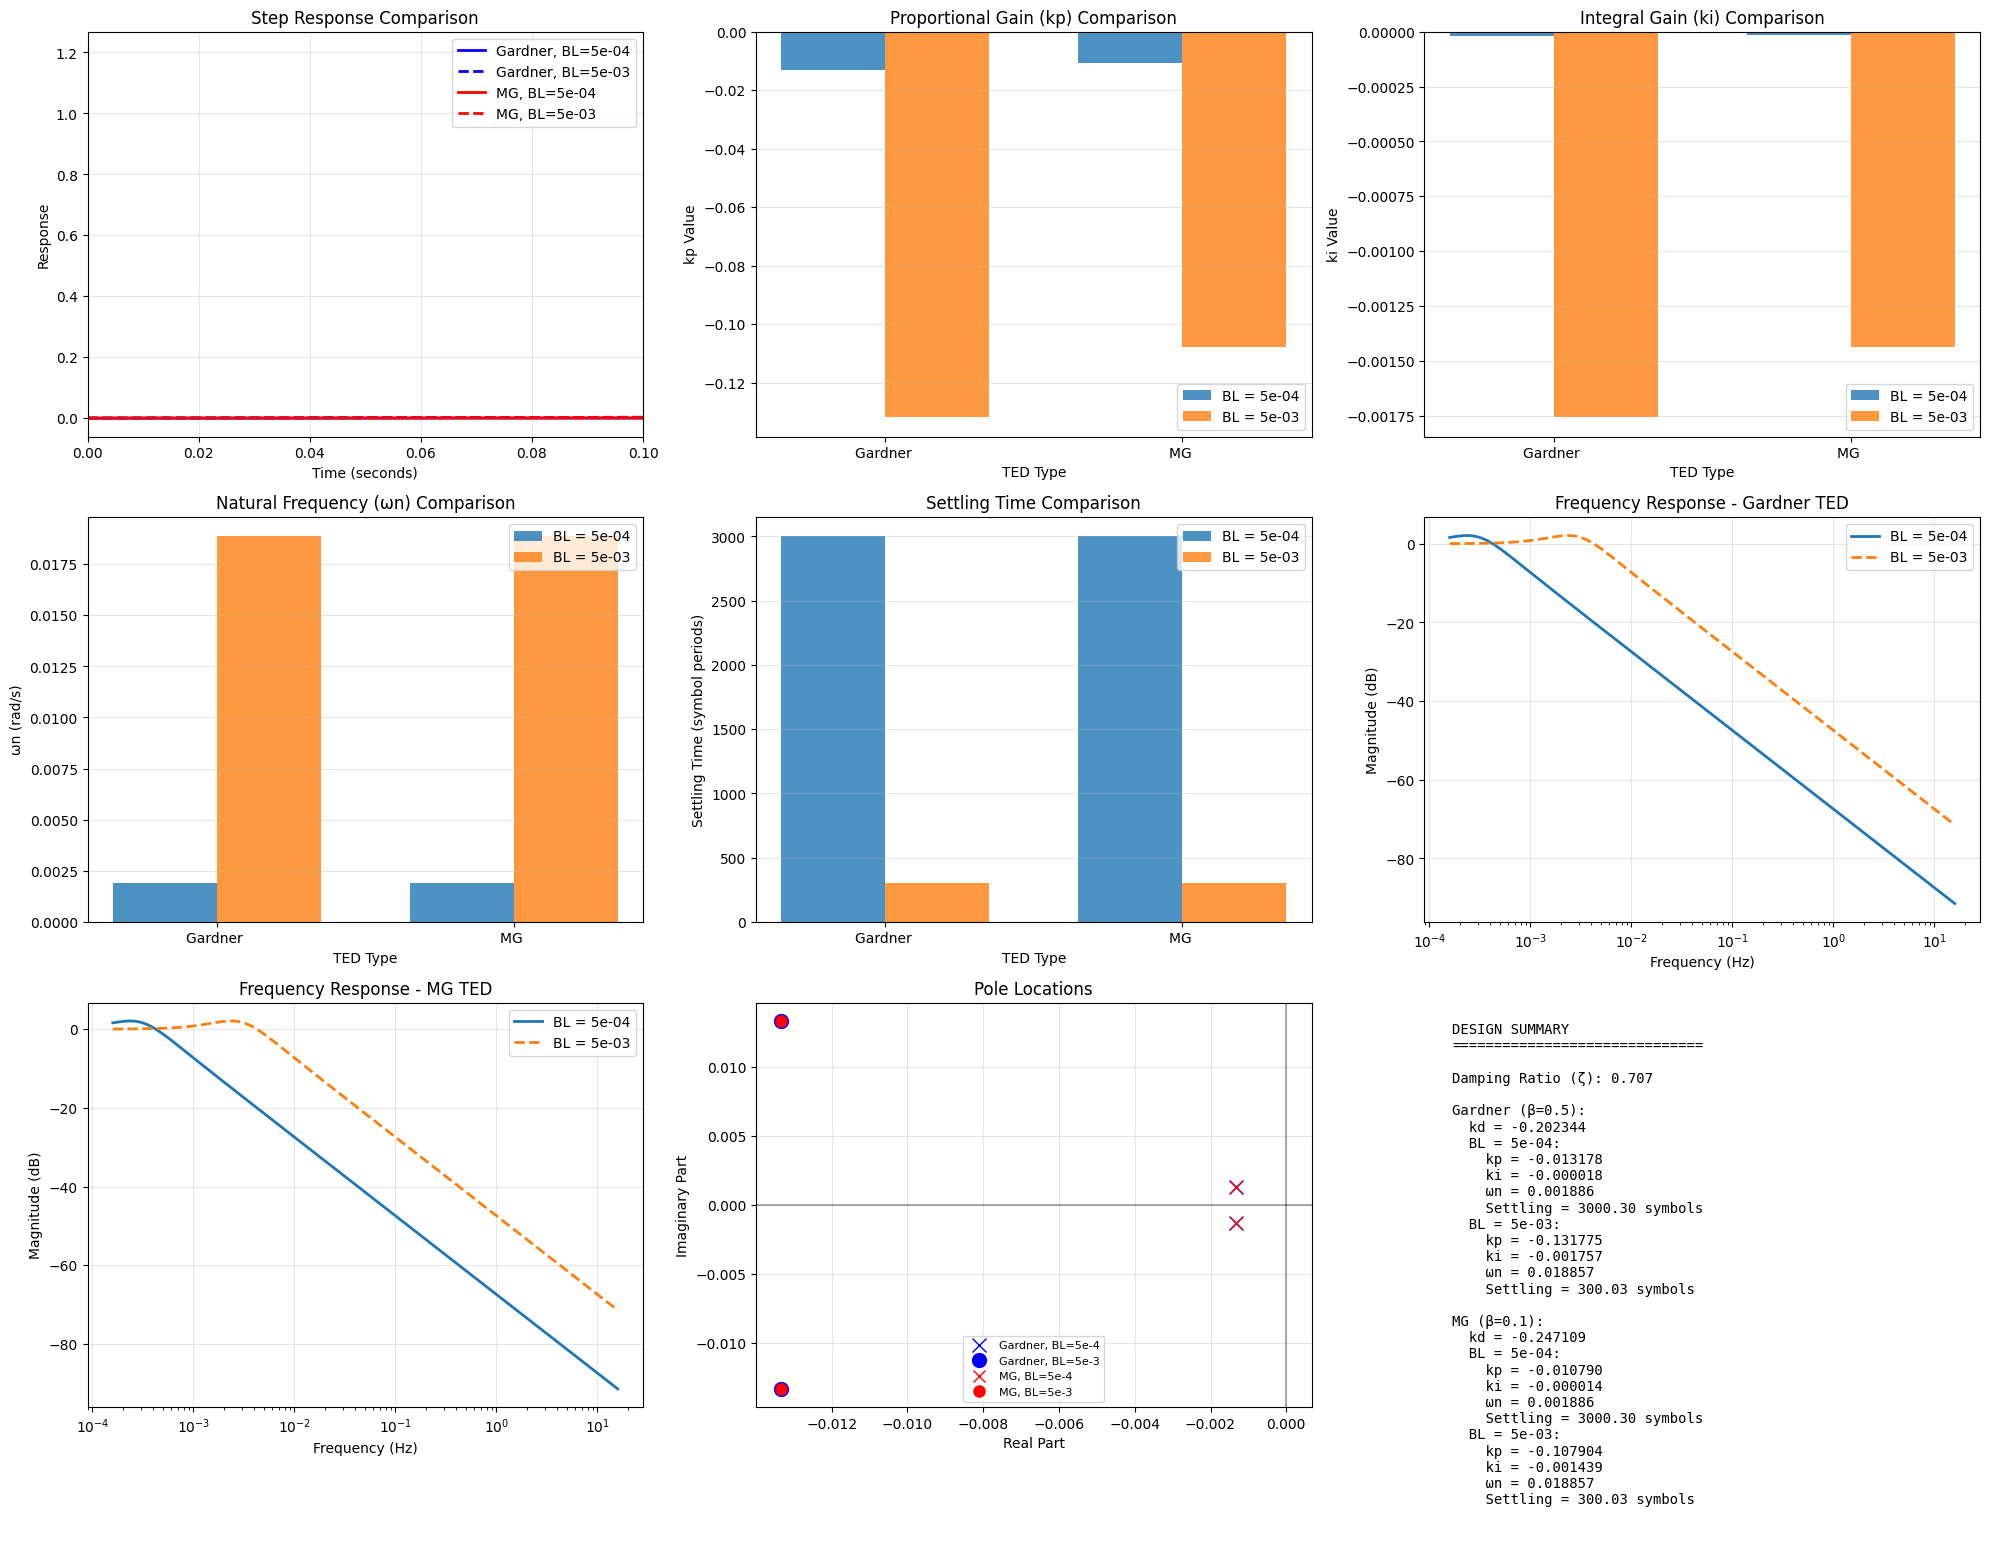


FINAL DESIGN SUMMARY TABLE
TED Type        BL         kd           kp           ki           ωn           Settling (sym) 
------------------------------------------------------------------------------------------
Gardner         5e-04      -0.202344    -0.013178    -0.000018    0.001886     3000.30        
Gardner         5e-03      -0.202344    -0.131775    -0.001757    0.018857     300.03         
MG              5e-04      -0.247109    -0.010790    -0.000014    0.001886     3000.30        
MG              5e-03      -0.247109    -0.107904    -0.001439    0.018857     300.03         

Key Observations:
- Higher BL leads to faster response (lower settling time) but potentially more noise
- Gardner TED generally requires different gains than MG TED due to different kd values
- All designs maintain ζ = 0.707 for optimal transient response
- The integral gain (ki) is proportional to ωn², while kp is proportional to ωn

Loop filter transfer function: F(s) = kp + ki/s
Closed-loop transfer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

# First, let's reproduce the key functions from your existing code to get kd values

def rrc_filter(beta, span, sps):
    """Generate Root Raised Cosine (RRC) filter"""
    t = np.arange(-span*sps//2, span*sps//2 + 1) / sps
    h = np.zeros_like(t)

    for i, time in enumerate(t):
        if time == 0:
            h[i] = (1 + beta * (4/np.pi - 1))
        elif abs(abs(time) - 1/(4*beta)) < 1e-10 and beta != 0:
            h[i] = (beta/np.sqrt(2)) * ((1 + 2/np.pi) * np.sin(np.pi/(4*beta)) +
                                        (1 - 2/np.pi) * np.cos(np.pi/(4*beta)))
        else:
            numerator = np.sin(np.pi * time * (1 - beta)) + 4 * beta * time * np.cos(np.pi * time * (1 + beta))
            denominator = np.pi * time * (1 - (4 * beta * time)**2)
            h[i] = numerator / denominator

    h = h / np.sqrt(np.sum(h**2))
    return t, h

def generate_data_symbols(N, constellation='BPSK'):
    """Generate random data symbols"""
    if constellation == 'BPSK':
        return 2 * np.random.randint(0, 2, N) - 1  # {-1, +1}
    elif constellation == 'QPSK':
        I = 2 * np.random.randint(0, 2, N) - 1
        Q = 2 * np.random.randint(0, 2, N) - 1
        return I + 1j * Q
    else:
        raise ValueError("Unsupported constellation")

def upsample_and_filter(symbols, rrc_impulse, sps):
    """Upsample symbols and apply RRC filtering"""
    upsampled = np.zeros(len(symbols) * sps, dtype=complex)
    upsampled[::sps] = symbols
    filtered = np.convolve(upsampled, rrc_impulse, mode='same')
    return filtered

def add_timing_offset(signal, offset_samples):
    """Add timing offset using fractional delay"""
    if abs(offset_samples) < 1e-10:
        return signal

    n_original = np.arange(len(signal))
    n_delayed = n_original - offset_samples

    f_real = interp1d(n_original, np.real(signal), kind='linear',
                      bounds_error=False, fill_value=0)
    f_imag = interp1d(n_original, np.imag(signal), kind='linear',
                      bounds_error=False, fill_value=0)

    delayed_signal = f_real(n_delayed) + 1j * f_imag(n_delayed)
    return delayed_signal

def gardner_ted(y, sps):
    """Gardner Timing Error Detector"""
    y_k = y[::sps]  # Symbol-rate samples
    y_k_half = y[sps//2::sps]  # Mid-symbol samples

    min_len = min(len(y_k), len(y_k_half))
    y_k = y_k[:min_len]
    y_k_half = y_k_half[:min_len-1] if len(y_k_half) > min_len-1 else y_k_half
    y_k_prev = y_k[:-1] if len(y_k) > 1 else y_k

    if len(y_k_half) == 0 or len(y_k_prev) == 0:
        return 0

    min_len = min(len(y_k_half), len(y_k_prev))
    y_k_half = y_k_half[:min_len]
    y_k_diff = (y_k[1:min_len+1] - y_k_prev[:min_len])

    error = np.real(y_k_half * np.conj(y_k_diff))
    return np.mean(error)

def mg_ted(y, sps):
    """Mueller-Gerke (MG) Timing Error Detector"""
    y_k = y[::sps]

    if len(y_k) < 2:
        return 0

    a_k = np.sign(np.real(y_k))
    a_diff = a_k[1:] - a_k[:-1]
    y_k_curr = y_k[1:]

    error = np.real(a_diff * np.conj(y_k_curr))
    return np.mean(error)

def compute_s_curve(ted_function, rrc_impulse, sps, tau_range, N_symbols=1000):
    """Compute S-curve for a given TED"""
    s_curve = []

    for tau in tau_range:
        errors = []
        for _ in range(10):  # Number of realizations for averaging
            symbols = generate_data_symbols(N_symbols, 'BPSK')
            tx_signal = upsample_and_filter(symbols, rrc_impulse, sps)
            rx_signal = add_timing_offset(tx_signal, tau)
            error = ted_function(rx_signal, sps)
            errors.append(error)
        s_curve.append(np.mean(errors))

    return np.array(s_curve)

def estimate_kd(tau_range, s_curve):
    """Estimate kd (derivative at tau=0)"""
    zero_idx = np.argmin(np.abs(tau_range))
    derivative = np.gradient(s_curve, tau_range)
    kd = derivative[zero_idx]
    return kd, derivative

# ============================================================================
# MAIN ANALYSIS: Calculate kd values from Problem 5
# ============================================================================

print("=== Timing Error Detector Analysis ===")
print("Calculating kd values for loop filter design...\n")

# Parameters
sps = 4  # Samples per symbol
span = 10  # Filter span in symbols
N_symbols = 2000  # Number of symbols

# Timing offset range (in samples)
tau_max = 1.0
tau_points = 101
tau_range = np.linspace(-tau_max, tau_max, tau_points)

# Calculate kd for Gardner TED with β = 0.5
beta_05 = 0.5
t_05, rrc_05 = rrc_filter(beta_05, span, sps)
s_curve_gardner_05 = compute_s_curve(gardner_ted, rrc_05, sps, tau_range, N_symbols)
kd_gardner_05, _ = estimate_kd(tau_range, s_curve_gardner_05)

# Calculate kd for MG TED with β = 0.1
beta_01 = 0.1
t_01, rrc_01 = rrc_filter(beta_01, span, sps)
s_curve_mg_01 = compute_s_curve(mg_ted, rrc_01, sps, tau_range, N_symbols)
kd_mg_01, _ = estimate_kd(tau_range, s_curve_mg_01)

print(f"Gardner TED (β = 0.5): kd = {kd_gardner_05:.6f}")
print(f"MG TED (β = 0.1): kd = {kd_mg_01:.6f}")

# ============================================================================
# ANALOG PI LOOP FILTER DESIGN
# ============================================================================

def design_analog_pi_filter(kd, zeta, BL, T_symbol):
    """
    Design analog proportional-integral loop filter

    Parameters:
    kd: Detector gain
    zeta: Damping ratio
    BL: Loop noise bandwidth (normalized to symbol rate)
    T_symbol: Symbol period

    Returns:
    kp: Proportional gain
    ki: Integral gain
    wn: Natural frequency
    """

    # Convert normalized bandwidth to actual bandwidth
    BL_actual = BL / T_symbol  # Hz

    # Natural frequency relationship for 2nd order PLL
    # BL = (wn/4) * (zeta + 1/(4*zeta))
    # Solve for wn
    wn = 4 * BL_actual / (zeta + 1/(4*zeta))

    # PI filter gains
    # For analog PI filter: F(s) = kp + ki/s
    # Standard relationships:
    kp = 2 * zeta * wn / kd
    ki = wn**2 / kd

    return kp, ki, wn, BL_actual

def analyze_loop_performance(kd, kp, ki, wn, zeta, BL_actual, T_symbol):
    """Analyze closed-loop performance"""

    # Closed-loop transfer function coefficients
    # H(s) = (kd*kp*s + kd*ki) / (s^2 + kd*kp*s + kd*ki)

    # Characteristic polynomial: s^2 + 2*zeta*wn*s + wn^2 = 0
    actual_2zeta_wn = kd * kp
    actual_wn_squared = kd * ki
    actual_wn = np.sqrt(actual_wn_squared)
    actual_zeta = actual_2zeta_wn / (2 * actual_wn)

    # Settling time (2% criterion)
    if actual_zeta > 0:
        settling_time = 4 / (actual_zeta * actual_wn)  # seconds
        settling_time_symbols = settling_time / T_symbol  # symbol periods
    else:
        settling_time = float('inf')
        settling_time_symbols = float('inf')

    # Peak overshoot
    if actual_zeta < 1 and actual_zeta > 0:
        overshoot = np.exp(-actual_zeta * np.pi / np.sqrt(1 - actual_zeta**2)) * 100
    else:
        overshoot = 0

    return {
        'actual_wn': actual_wn,
        'actual_zeta': actual_zeta,
        'settling_time': settling_time,
        'settling_time_symbols': settling_time_symbols,
        'overshoot_percent': overshoot,
        'BL_actual': BL_actual
    }

def plot_step_response(kd, kp, ki, wn, title_suffix=""):
    """Plot step response of the closed-loop system"""

    # Transfer function: H(s) = (kd*kp*s + kd*ki) / (s^2 + kd*kp*s + kd*ki)
    num = [kd*kp, kd*ki]
    den = [1, kd*kp, kd*ki]

    system = signal.TransferFunction(num, den)

    # Time vector
    t = np.linspace(0, 10/wn, 1000)  # 10 time constants

    # Step response
    t_step, y_step = signal.step(system, T=t)

    return t_step, y_step

# ============================================================================
# DESIGN CALCULATIONS
# ============================================================================

print("\n" + "="*70)
print("ANALOG PI LOOP FILTER DESIGN")
print("="*70)

# Design parameters
zeta = 0.707  # Damping ratio
T_symbol = 1.0  # Symbol period (normalized)
BL_values = [0.5e-3, 5e-3]  # Noise bandwidth values

# We'll use both kd values for comprehensive analysis
kd_values = {
    'Gardner (β=0.5)': kd_gardner_05,
    'MG (β=0.1)': kd_mg_01
}

print(f"Design Specifications:")
print(f"- Damping ratio (ζ): {zeta}")
print(f"- Symbol period (T): {T_symbol}")
print(f"- Noise bandwidth values (BL): {BL_values}")
print()

# Store results for plotting
results = {}

for ted_name, kd in kd_values.items():
    print(f"\n{ted_name} (kd = {kd:.6f}):")
    print("-" * 50)

    results[ted_name] = {}

    for BL in BL_values:
        print(f"\nNoise Bandwidth BL = {BL:.1e}:")

        # Design the filter
        kp, ki, wn, BL_actual = design_analog_pi_filter(kd, zeta, BL, T_symbol)

        # Analyze performance
        performance = analyze_loop_performance(kd, kp, ki, wn, zeta, BL_actual, T_symbol)

        # Store results
        results[ted_name][BL] = {
            'kp': kp, 'ki': ki, 'wn': wn, 'BL_actual': BL_actual,
            'performance': performance
        }

        print(f"  Filter Gains:")
        print(f"    kp (proportional): {kp:.6f}")
        print(f"    ki (integral):     {ki:.6f}")
        print(f"  Loop Parameters:")
        print(f"    Natural frequency (wn):     {wn:.6f} rad/s")
        print(f"    Actual bandwidth (BL):      {BL_actual:.6f} Hz")
        print(f"  Performance:")
        print(f"    Actual damping ratio:       {performance['actual_zeta']:.6f}")
        print(f"    Settling time:              {performance['settling_time']:.6f} s")
        print(f"    Settling time (symbols):    {performance['settling_time_symbols']:.6f}")
        print(f"    Peak overshoot:             {performance['overshoot_percent']:.2f}%")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("GENERATING PLOTS...")
print("="*70)

# Create comprehensive plots
fig = plt.figure(figsize=(20, 16))

# Plot 1: Step Responses
plt.subplot(3, 3, 1)
colors = ['blue', 'red']
linestyles = ['-', '--']

for i, (ted_name, kd) in enumerate(kd_values.items()):
    for j, BL in enumerate(BL_values):
        result = results[ted_name][BL]
        t_step, y_step = plot_step_response(kd, result['kp'], result['ki'], result['wn'])

        label = f"{ted_name.split('(')[0].strip()}, BL={BL:.0e}"
        plt.plot(t_step, y_step, color=colors[i], linestyle=linestyles[j],
                linewidth=2, label=label)

plt.title('Step Response Comparison')
plt.xlabel('Time (seconds)')
plt.ylabel('Response')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 0.1)

# Plot 2: Filter Gains Comparison
plt.subplot(3, 3, 2)
ted_names = list(kd_values.keys())
kp_low = [results[name][BL_values[0]]['kp'] for name in ted_names]
kp_high = [results[name][BL_values[1]]['kp'] for name in ted_names]

x = np.arange(len(ted_names))
width = 0.35

plt.bar(x - width/2, kp_low, width, label=f'BL = {BL_values[0]:.0e}', alpha=0.8)
plt.bar(x + width/2, kp_high, width, label=f'BL = {BL_values[1]:.0e}', alpha=0.8)

plt.title('Proportional Gain (kp) Comparison')
plt.xlabel('TED Type')
plt.ylabel('kp Value')
plt.xticks(x, [name.split('(')[0] for name in ted_names])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Plot 3: Integral Gains Comparison
plt.subplot(3, 3, 3)
ki_low = [results[name][BL_values[0]]['ki'] for name in ted_names]
ki_high = [results[name][BL_values[1]]['ki'] for name in ted_names]

plt.bar(x - width/2, ki_low, width, label=f'BL = {BL_values[0]:.0e}', alpha=0.8)
plt.bar(x + width/2, ki_high, width, label=f'BL = {BL_values[1]:.0e}', alpha=0.8)

plt.title('Integral Gain (ki) Comparison')
plt.xlabel('TED Type')
plt.ylabel('ki Value')
plt.xticks(x, [name.split('(')[0] for name in ted_names])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Plot 4: Natural Frequency Comparison
plt.subplot(3, 3, 4)
wn_low = [results[name][BL_values[0]]['wn'] for name in ted_names]
wn_high = [results[name][BL_values[1]]['wn'] for name in ted_names]

plt.bar(x - width/2, wn_low, width, label=f'BL = {BL_values[0]:.0e}', alpha=0.8)
plt.bar(x + width/2, wn_high, width, label=f'BL = {BL_values[1]:.0e}', alpha=0.8)

plt.title('Natural Frequency (ωn) Comparison')
plt.xlabel('TED Type')
plt.ylabel('ωn (rad/s)')
plt.xticks(x, [name.split('(')[0] for name in ted_names])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Plot 5: Settling Time Comparison
plt.subplot(3, 3, 5)
settling_low = [results[name][BL_values[0]]['performance']['settling_time_symbols'] for name in ted_names]
settling_high = [results[name][BL_values[1]]['performance']['settling_time_symbols'] for name in ted_names]

plt.bar(x - width/2, settling_low, width, label=f'BL = {BL_values[0]:.0e}', alpha=0.8)
plt.bar(x + width/2, settling_high, width, label=f'BL = {BL_values[1]:.0e}', alpha=0.8)

plt.title('Settling Time Comparison')
plt.xlabel('TED Type')
plt.ylabel('Settling Time (symbol periods)')
plt.xticks(x, [name.split('(')[0] for name in ted_names])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Plot 6: Frequency Response - Gardner TED
plt.subplot(3, 3, 6)
for j, BL in enumerate(BL_values):
    ted_name = 'Gardner (β=0.5)'
    result = results[ted_name][BL]
    kd = kd_values[ted_name]

    # Create transfer function
    num = [kd*result['kp'], kd*result['ki']]
    den = [1, kd*result['kp'], kd*result['ki']]
    system = signal.TransferFunction(num, den)

    # Frequency response
    w, h = signal.freqresp(system, w=np.logspace(-3, 2, 1000))

    plt.semilogx(w/(2*np.pi), 20*np.log10(np.abs(h)),
                linestyle=linestyles[j], linewidth=2,
                label=f'BL = {BL:.0e}')

plt.title('Frequency Response - Gardner TED')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 7: Frequency Response - MG TED
plt.subplot(3, 3, 7)
for j, BL in enumerate(BL_values):
    ted_name = 'MG (β=0.1)'
    result = results[ted_name][BL]
    kd = kd_values[ted_name]

    # Create transfer function
    num = [kd*result['kp'], kd*result['ki']]
    den = [1, kd*result['kp'], kd*result['ki']]
    system = signal.TransferFunction(num, den)

    # Frequency response
    w, h = signal.freqresp(system, w=np.logspace(-3, 2, 1000))

    plt.semilogx(w/(2*np.pi), 20*np.log10(np.abs(h)),
                linestyle=linestyles[j], linewidth=2,
                label=f'BL = {BL:.0e}')

plt.title('Frequency Response - MG TED')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 8: Pole-Zero Map
plt.subplot(3, 3, 8)
for i, (ted_name, kd) in enumerate(kd_values.items()):
    for j, BL in enumerate(BL_values):
        result = results[ted_name][BL]

        # Calculate poles
        a = 1
        b = kd * result['kp']
        c = kd * result['ki']

        # Solve s^2 + bs + c = 0
        discriminant = b**2 - 4*a*c
        if discriminant >= 0:
            pole1 = (-b + np.sqrt(discriminant)) / (2*a)
            pole2 = (-b - np.sqrt(discriminant)) / (2*a)
            poles = [pole1, pole2]
        else:
            real_part = -b / (2*a)
            imag_part = np.sqrt(-discriminant) / (2*a)
            pole1 = real_part + 1j*imag_part
            pole2 = real_part - 1j*imag_part
            poles = [pole1, pole2]

        # Plot poles
        for pole in poles:
            marker = 'x' if j == 0 else 'o'
            size = 10 if i == 0 else 8
            plt.plot(np.real(pole), np.imag(pole), marker=marker,
                    color=colors[i], markersize=size)

plt.title('Pole Locations')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Create custom legend for pole plot
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='x', color='blue', linestyle='None', markersize=10, label='Gardner, BL=5e-4'),
    Line2D([0], [0], marker='o', color='blue', linestyle='None', markersize=10, label='Gardner, BL=5e-3'),
    Line2D([0], [0], marker='x', color='red', linestyle='None', markersize=8, label='MG, BL=5e-4'),
    Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=8, label='MG, BL=5e-3')
]
plt.legend(handles=legend_elements, fontsize=8)

# Plot 9: Summary Table (as text)
plt.subplot(3, 3, 9)
plt.axis('off')

# Create summary text
summary_text = "DESIGN SUMMARY\n" + "="*30 + "\n\n"
summary_text += f"Damping Ratio (ζ): {zeta}\n\n"

for ted_name, kd in kd_values.items():
    summary_text += f"{ted_name}:\n"
    summary_text += f"  kd = {kd:.6f}\n"
    for BL in BL_values:
        result = results[ted_name][BL]
        summary_text += f"  BL = {BL:.0e}:\n"
        summary_text += f"    kp = {result['kp']:.6f}\n"
        summary_text += f"    ki = {result['ki']:.6f}\n"
        summary_text += f"    ωn = {result['wn']:.6f}\n"
        summary_text += f"    Settling = {result['performance']['settling_time_symbols']:.2f} symbols\n"
    summary_text += "\n"

plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

# ============================================================================
# FINAL SUMMARY TABLE
# ============================================================================

print("\n" + "="*90)
print("FINAL DESIGN SUMMARY TABLE")
print("="*90)

print(f"{'TED Type':<15} {'BL':<10} {'kd':<12} {'kp':<12} {'ki':<12} {'ωn':<12} {'Settling (sym)':<15}")
print("-" * 90)

for ted_name, kd in kd_values.items():
    ted_short = ted_name.split('(')[0].strip()
    for BL in BL_values:
        result = results[ted_name][BL]
        settling = result['performance']['settling_time_symbols']

        print(f"{ted_short:<15} {BL:<10.0e} {kd:<12.6f} {result['kp']:<12.6f} "
              f"{result['ki']:<12.6f} {result['wn']:<12.6f} {settling:<15.2f}")

print("\nKey Observations:")
print("- Higher BL leads to faster response (lower settling time) but potentially more noise")
print("- Gardner TED generally requires different gains than MG TED due to different kd values")
print("- All designs maintain ζ = 0.707 for optimal transient response")
print("- The integral gain (ki) is proportional to ωn², while kp is proportional to ωn")

print(f"\nLoop filter transfer function: F(s) = kp + ki/s")
print(f"Closed-loop transfer function: H(s) = (kd·kp·s + kd·ki)/(s² + kd·kp·s + kd·ki)")
print(f"Design equations:")
print(f"  ωn = 4·BL/(ζ + 1/(4ζ))")
print(f"  kp = 2·ζ·ωn/kd")
print(f"  ki = ωn²/kd")

print("\n" + "="*90)
print("ANALYSIS COMPLETE!")
print("="*90)